# The contents of this notebook is the code behind the ***VGP Calculator Widget*** application. 
## To launch to application, simply run the cell below
A thorought description of the application's functionality is provided in the report. Providing a documentation of all the functions would be superfluous, considering that this part of the project is designed to be interacted with at the application level only, not by running functions inside the notebook. We shall only provide some basic notions about the code here:
- The class **site_data** is based on the class with the same name in the other notebook (*CMAG_Project_Team1-Visualizing_VGP_with_static_plots_and_animatons.ipynb*), but with significant changes in accordance to the needs of the application
- Function ***is_num*** works similarly as a *Python string* method **.isnumeric()**, but it is able to recognize any kind of *string* input that can be interpreted as a **float** (e. g. "1.4", "-7", "-9.2322")
- Function ***format_coordinates** turns input coordinates such provided in a **float** format into a *string* format with degrees, minutes, seconds and S/N, W/E indicators
- Function ***VGP*** is the same as in *CMAG_Project_Team1-Visualizing_VGP_with_static_plots_and_animatons.ipynb* except it returs the angles in degrees, which is convenient for displaying on the Plate carrée map projection
- Class **VGPApp** is the "driving engine" of the application, with definition of the layout and functions defining how the widgets work and interact, so as to provide the functionalities introduced in the report

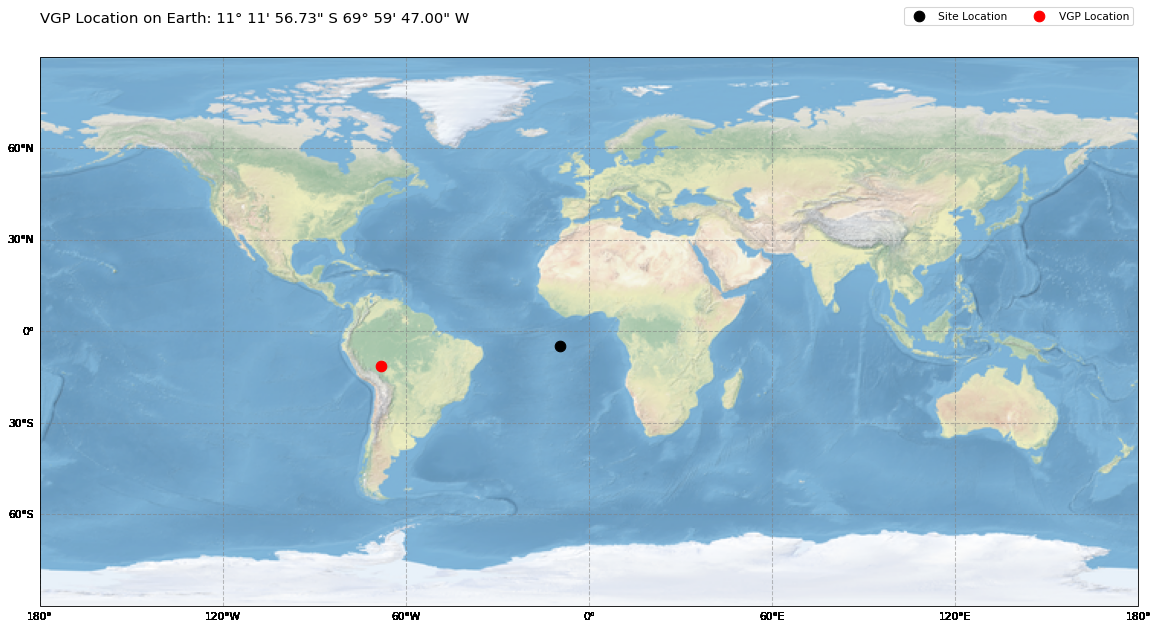

In [75]:
import tkinter as tk
from tkinter import Entry, Button, Label, Toplevel, ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.patches import PathPatch
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from io import BytesIO
from PIL import Image, ImageTk
import matplotlib.cm as cm
from scipy.interpolate import splprep, splev

class site_data:

    def __init__(self,lat,lon,file,file_header=0):
        data=np.genfromtxt(file,skip_header=file_header)
        self.latitude=lat
        self.longitude=lon
        self.T = data[:,0]*1000
        self.D = data[:,1]
        self.I = data[:,2]
        self.recalculate(self.latitude,self.longitude)
        
    def recalculate(self,lat,lon):
        self.latitude=lat
        self.longitude=lon        
        self.VGPs = np.array(list(map(lambda i: VGP(self.latitude,self.longitude,np.radians(self.I[i]),np.radians(self.D[i])),range(len(self.I))))).T
        tck, u = splprep([(self.VGPs[1]+180)%360-180, self.VGPs[0]],s=0)    
        self.B_spline_tck=tck
        self.B_spline_u=u
        self.B_spline_to_plot=self.B_spline_curve()
        
    def B_spline_curve(self,resolution=10):
        u_new = np.linspace(self.B_spline_u[0], self.B_spline_u[-1], len(self.T)*resolution)
        curve = splev(u_new, self.B_spline_tck)      
        return curve[0],curve[1]
    
def isnum(s):
    try:
        float(s)
    except ValueError:
        return False
    else:
        return True
    
def format_coordinates(latlon):
        # Format latitude
    lat_deg, lat_min = divmod(abs(latlon[0]), 1)
    lat_min, lat_sec = divmod(lat_min * 60, 1)
    lat_sec *= 60
    lat_dir = 'N' if latlon[0] >= 0 else 'S'

    # Format longitude
    lon_deg, lon_min = divmod(latlon[1], 1)
    lon_min, lon_sec = divmod(lon_min * 60, 1)
    lon_sec *= 60

    # Ensure longitude is between 0 and 180 degrees
    lon_deg = lon_deg % 360  # Wrap around in case it's greater than 360
    if lon_deg > 180:
        lon_deg = 360 - lon_deg
        lon_dir = 'W'
    else:
        lon_dir = 'E'
    lat_str=f"{int(lat_deg)}° {int(lat_min)}' {lat_sec:.2f}\" {lat_dir}"
    lon_str=f"{int(lon_deg)}° {int(lon_min)}' {lon_sec:.2f}\" {lon_dir}"
    return lat_str,lon_str


def VGP(lat, lon, I, D):
    p = np.arctan(2/(np.tan(I)))
    cp = np.cos(p)
    sp = np.sin(p)
    slp = np.sin(lat)*cp+np.cos(lat)*sp*np.cos(D)
    lat_pole = np.arcsin(slp)
    beta = np.arcsin(sp*np.sin(D)/np.cos(lat_pole))
    crit = np.sin(lat)*slp
    if cp >= crit:
        lon_pole = lon + beta
    else:
        lon_pole = lon+np.pi-beta
    if lon_pole < 0:
        lon_pole += 2*np.pi
    return [np.degrees(lat_pole), np.degrees(lon_pole)]

class VGPApp:
    def __init__(self, master):
        self.master = master
        self.object_data=None
        master.title("Virtual Geomagnetic Pole Calculator")
        master.geometry("1720x800")  # Initial size of the main window
        self.stop_animation = False
        self.once_calculated=False  
        self.initial_launch=True
        style = ttk.Style()
        style.configure("TButton", padding=(10, 5), font=('Helvetica', 12))
        style.configure("TLabel", font=('Helvetica', 12))
        style.configure("TEntry", font=('Helvetica', 12))
        
        self.fig, self.ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(16, 9))
        self.fig.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95)
        self.ax.stock_img()
        self.ax.set_xlabel('Longitude', fontsize=12)
        self.ax.set_ylabel('Latitude', fontsize=12)
        self.ax.set_title('Welcome. Define inclination and declination manually, or load a file and move the slider to show VGP location',y=1.05, x=0.374,fontsize=14)
        gl = self.ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

        gl.top_labels = False
        gl.right_labels = False
        rowspan_map=17
        columnspan_map=8
        self.frame = ttk.Frame(master, borderwidth=2, relief="solid")
        self.frame.grid(row=0, column=0, rowspan=rowspan_map+2, columnspan=columnspan_map+6, pady=10, padx=15, sticky="nsew")
        self.plot_canvas = FigureCanvasTkAgg(self.fig, master=self.master)
        self.plot_widget = self.plot_canvas.get_tk_widget()
        self.plot_widget.grid(row=0,column=0,rowspan=rowspan_map,columnspan=columnspan_map,padx=25,pady=15)

        self.lat_value_var = tk.DoubleVar()
        self.lat_slider = ttk.Scale(master, from_=-90, to=90, variable=self.lat_value_var, orient=tk.HORIZONTAL, length=300)
        self.lat_slider.grid(row=1, column=columnspan_map+1, columnspan=4,pady=5)
        self.lat_min_label = ttk.Label(master, text="-90°     ")
        self.lat_min_label.grid(row=1, column=columnspan_map, pady=5, sticky="e")

        self.lat_max_label = ttk.Label(master, text="90°")
        self.lat_max_label.grid(row=1, column=columnspan_map+5, pady=5, padx=25,sticky="w")

        self.lat_current_label = ttk.Label(master, text="           Latitude: 39.55°")
        self.lat_current_label.grid(row=0, column=columnspan_map+1, columnspan=4, pady=15, sticky="ew")
        
        self.lat_value_var.trace_add("write", self.update_latitude_slider_label)

        self.lon_value_var = tk.DoubleVar()
        self.lon_slider = ttk.Scale(master, from_=-180, to=180, variable=self.lon_value_var, orient=tk.HORIZONTAL, length=300)
        self.lon_slider.grid(row=3, column=columnspan_map+1, columnspan=4, pady=5)

        self.lon_min_label = ttk.Label(master, text="-180°     ")
        self.lon_min_label.grid(row=3, column=columnspan_map, pady=5, sticky="e")

        self.lon_max_label = ttk.Label(master, text="180°")
        self.lon_max_label.grid(row=3, column=columnspan_map+5, pady=5, padx=25, sticky="w")

        self.lon_current_label = ttk.Label(master, text="           Longitude: -8.77°")
        self.lon_current_label.grid(row=2, column=columnspan_map+1, columnspan=4, pady=5, sticky="ew")
        
        self.lon_value_var.trace_add("write", self.update_longitude_slider_label)
        
        self.manual_frame = ttk.Frame(master, borderwidth=2, relief="solid")
        self.manual_frame.grid(row=5, column=columnspan_map, rowspan=5, columnspan=5, pady=10, padx=5, sticky="nsew")

        self.file_frame = ttk.Frame(master, borderwidth=2, relief="solid")
        self.file_frame.grid(row=11, column=columnspan_map, rowspan=5, columnspan=5, pady=10, padx=5, sticky="nsew")
        
        self.unit_var = tk.StringVar(value="degrees")
        self.unit_label = ttk.Label(master, text="Input Units:")
        self.unit_label.grid(row=6, column=columnspan_map, columnspan=2,pady=5,sticky="e")
        self.unit_dropdown = ttk.Combobox(master, textvariable=self.unit_var, values=["degrees", "radians"])
        self.unit_dropdown.grid(row=6, column=columnspan_map+2, columnspan=2,pady=5,sticky="w")
        self.unit_dropdown["state"] = "readonly"
        self.unit_dropdown.current(0)
        
        self.inclination_label = ttk.Label(master, text="Inclination:")
        self.inclination_label.grid(row=7, column=columnspan_map, columnspan=2, pady=5,sticky="e")

        self.inclination_entry = ttk.Entry(master)
        self.inclination_entry.grid(row=7, column=columnspan_map+2, columnspan=2,pady=5,sticky="w")
        
        self.inc_value_label = ttk.Label(master, text="")
        self.inc_value_label.grid(row=7, column=columnspan_map+2, columnspan=2,pady=5,sticky="w")

        self.declination_label = ttk.Label(master, text="Declination:")
        self.declination_label.grid(row=8, column=columnspan_map, columnspan=2,pady=5,sticky="e")

        self.declination_entry = ttk.Entry(master)
        self.declination_entry.grid(row=8, column=columnspan_map+2, columnspan=2,pady=5,sticky="w")

        self.dec_value_label = ttk.Label(master, text="")
        self.dec_value_label.grid(row=8, column=columnspan_map+2, columnspan=2,pady=5,sticky="w")
        
        self.file_header_label = ttk.Label(master, text="Header lines:")
        self.file_header_label.grid(row=12, column=columnspan_map, columnspan=2,pady=5,padx=5,sticky="e")

        self.header_var=1
        self.header_dropdown = ttk.Combobox(master, textvariable=self.header_var, values=[0,1,2,3,4,5])
        self.header_dropdown.grid(row=12, column=columnspan_map+2, columnspan=2,pady=5,sticky="w")
        self.header_dropdown["state"] = "readonly"
        self.header_dropdown.current(1)
        
        self.load_data_button = ttk.Button(master, text="Load Paleomagnetic Data File", command=self.load_data_from_file)
        self.load_data_button.grid(row=13, column=columnspan_map, columnspan=5, pady=10)
        
        self.result_label = ttk.Label(master, text="")
        self.result_label.grid(row=16, column=columnspan_map, columnspan=6,rowspan=2,pady=0)  
        
        self.result_label2 = ttk.Label(master, text="")
        self.result_label2.grid(row=10, column=columnspan_map, columnspan=6,rowspan=1,pady=0)  
        
        self.T_value_var = tk.DoubleVar()
        self.T_slider = ttk.Scale(master, from_=0, to=0, variable=self.T_value_var, orient=tk.HORIZONTAL, length=850)
        self.T_slider.grid(row=rowspan_map, column=1, columnspan=columnspan_map-2,pady=5,sticky="w")

        
        self.T_min_label = ttk.Label(master, text="  From 00000.0 years ago   ")
        self.T_min_label.grid(row=rowspan_map, column=0, pady=5, padx=20,sticky="w")

        self.T_max_label = ttk.Label(master, text="   To 00000.0 years ago")
        self.T_max_label.grid(row=rowspan_map, column=columnspan_map-1, pady=5, sticky="w")

        self.T_current_label = ttk.Label(master, text="   Current T: 00000.0 years ago")
        self.T_current_label.grid(row=rowspan_map+1, column=3, pady=15, sticky="ew")

        self.T_value_var.trace_add("write", self.update_slider_labels)
        
        self.left_arrow_button = ttk.Button(master, text="◀", command=self.step_slider_left, style="TButton")
        self.left_arrow_button.grid(row=rowspan_map + 1, column=2, pady=15, sticky="e")

        self.right_arrow_button = ttk.Button(master, text="▶", command=self.step_slider_right, style="TButton")
        self.right_arrow_button.grid(row=rowspan_map + 1, column=4, pady=15, sticky="w")
        
        self.left_anim_button = ttk.Button(master, text="◀◀", command=self.play_slider_left, style="TButton")
        self.left_anim_button.grid(row=rowspan_map + 1, column=1, pady=15, sticky="e")

        self.right_anim_button = ttk.Button(master, text="▶▶", command=self.play_slider_right, style="TButton")
        self.right_anim_button.grid(row=rowspan_map + 1, column=5, pady=15, sticky="w")
        
        self.stop_button = ttk.Button(master, text="\u25A0", command=self.stop_animation_method)
        self.stop_button.grid(row=rowspan_map + 1, column=6, pady=15, sticky="nsew")
        
        self.input_mode_var = tk.StringVar(value="manual")
        self.manual_radio = ttk.Radiobutton(master, text="Manual input", variable=self.input_mode_var, value="manual", command=self.toggle_input_mode)
        self.manual_radio.grid(row=5, column=columnspan_map, columnspan=2,pady=15,padx=15)

        self.load_file_radio = ttk.Radiobutton(master, text="Load data file", variable=self.input_mode_var, value="load_file", command=self.toggle_input_mode)
        self.load_file_radio.grid(row=11, column=columnspan_map, columnspan=2,pady=15,padx=15)
        
        self.display_path_label = ttk.Label(master, text="Display full VGP path")
        self.display_path_label.grid(row=14, column=columnspan_map, columnspan=5,pady=0)  
        
        self.display_mode_var = tk.StringVar(value="no")
        self.dont_display_radio = ttk.Radiobutton(master, text="No", variable=self.display_mode_var, value="no")
        self.dont_display_radio.grid(row=15, column=columnspan_map, columnspan=2,pady=10,padx=0)
        
        self.straight_display_radio = ttk.Radiobutton(master, text="Straight lines", variable=self.display_mode_var, value="straight")
        self.straight_display_radio.grid(row=15, column=columnspan_map+2, pady=10,padx=0,sticky="w")
        
        self.bspline_display_radio = ttk.Radiobutton(master, text="B-spline", variable=self.display_mode_var, value="bspline")
        self.bspline_display_radio.grid(row=15, column=columnspan_map+3, pady=10,padx=5,sticky="w")

        self.display_mode_var.trace_add("write", self.update_when_changing_display)
        
        self.calculate_button = ttk.Button(master, text="Calculate VGP", command=self.calculate_vgp)
        self.calculate_button.grid(row=9, column=columnspan_map, columnspan=5, pady=10)

        self.unit_var.trace_add("write", self.update_when_changing_unit)
        self.toggle_input_mode()
        self.lat_slider.set(39.548183333333334)
        self.lon_slider.set(-8.7711)
        self.initial_launch=False
        
    def step_slider_left(self):
        current_value = int(self.T_value_var.get())
        min_value = int(self.T_slider.cget("from"))

        if current_value > min_value:
            self.T_value_var.set(current_value - 1)
            self.update_slider_labels()

    def step_slider_right(self):
        current_value = int(self.T_value_var.get())
        max_value = int(self.T_slider.cget("to"))

        if current_value < max_value:
            self.T_value_var.set(current_value + 1)
            self.update_slider_labels()
            
    def play_slider_left(self):
        if not self.stop_animation:
            for feature in [self.lat_slider, self.lon_slider,self.manual_radio, self.load_file_radio, self.inclination_entry, self.declination_entry, self.unit_dropdown,self.calculate_button,self.load_data_button,self.header_dropdown,self.T_slider,self.left_arrow_button,self.right_arrow_button,self.right_anim_button,self.dont_display_radio,self.straight_display_radio,self.bspline_display_radio]:
                feature["state"]="disabled"
            self.step_slider_left()

            if self.T_value_var.get() <= int(self.T_slider.cget("from")):
                    self.stop_animation=True
            self.master.after(1, self.play_slider_left)
        else:
            self.stop_animation=False
            for feature in [self.lat_slider, self.lon_slider,self.manual_radio, self.load_file_radio, self.inclination_entry, self.declination_entry, self.unit_dropdown,self.calculate_button,self.load_data_button,self.header_dropdown,self.T_slider,self.left_arrow_button,self.right_arrow_button,self.right_anim_button,self.dont_display_radio,self.straight_display_radio,self.bspline_display_radio]:

                feature["state"]="normal"
                self.toggle_input_mode()
            

    def play_slider_right(self):
        if not self.stop_animation:
            for feature in [self.lat_slider, self.lon_slider,self.manual_radio, self.load_file_radio, self.inclination_entry, self.declination_entry, self.unit_dropdown,self.calculate_button,self.load_data_button,self.header_dropdown,self.T_slider,self.left_arrow_button,self.right_arrow_button,self.right_anim_button,self.dont_display_radio,self.straight_display_radio,self.bspline_display_radio]:
                feature["state"]="disabled"
            self.step_slider_right()

            if self.T_value_var.get() >= int(self.T_slider.cget("to")):
                self.stop_animation=True
            self.master.after(1, self.play_slider_right)
        else:
            self.stop_animation=False
            for feature in [self.lat_slider, self.lon_slider,self.manual_radio, self.load_file_radio, self.inclination_entry, self.declination_entry, self.unit_dropdown,self.calculate_button,self.load_data_button,self.header_dropdown,self.T_slider,self.left_arrow_button,self.right_arrow_button,self.right_anim_button,self.dont_display_radio,self.straight_display_radio,self.bspline_display_radio]:
                feature["state"]="normal"
                self.toggle_input_mode()
        
    def stop_animation_method(self):
        self.stop_animation = True
        
    def update_slider_labels(self, *args):
        if self.object_data is None:
            min_value = self.T_slider.cget("from")
            max_value = self.T_slider.cget("to")
            current_value = "{:0.1f}".format(self.T_value_var.get())
        else:
            min_value = self.object_data.T[self.T_slider.cget("from")]
            max_value = self.object_data.T[self.T_slider.cget("to")]
            current_value = self.object_data.T[int(self.T_value_var.get())]
            self.calculate_vgp()
        self.T_min_label.config(text=f"  From {min_value} years ago   ")
        self.T_max_label.config(text=f"   To {max_value} years ago")
        self.T_current_label.config(text=f"   Current T: {current_value} years ago")
    
    def update_latitude_slider_label(self, *args):
        self.lat_current_label.config(text="           Latitude: {:0.2f}°".format(self.lat_value_var.get()))  
        if (isnum(self.inclination_entry.get()) and isnum(self.declination_entry.get())) or (self.object_data is not None):
            if self.object_data is not None:
                self.object_data.recalculate(np.radians(self.lat_value_var.get()),np.radians(self.lon_value_var.get()))
            self.calculate_vgp()
        else:
            self.show_site()
        
    def update_when_changing_unit(self, *args):
        if (isnum(self.inclination_entry.get()) and isnum(self.declination_entry.get())) and (self.input_mode_var.get()=="manual") and self.once_calculated:
            self.calculate_vgp()

    def update_when_changing_display(self, *args):
        if (self.input_mode_var.get()=="load_file") and (self.object_data is not None):
            self.calculate_vgp()
    
    def update_longitude_slider_label(self, *args):
        self.lon_current_label.config(text="           Longitude: {:0.2f}°".format(self.lon_value_var.get()))    
        if (isnum(self.inclination_entry.get()) and isnum(self.declination_entry.get())) or (self.object_data is not None):
            if self.object_data is not None:
                self.object_data.recalculate(np.radians(self.lat_value_var.get()),np.radians(self.lon_value_var.get()))
            self.calculate_vgp()
        else:
            self.show_site()
        
    def load_data_from_file(self):
        lat_degrees = float(self.lat_value_var.get())
        lon_degrees = float(self.lon_value_var.get())
        input_units = self.unit_var.get()
        file_header = self.header_var
        if input_units == "degrees":
            lat = np.radians(lat_degrees)
            lon = np.radians(lon_degrees)
        else:
            lat = lat_degrees
            lon = lon_degrees

        file_path = tk.filedialog.askopenfilename(title="Select Data File", filetypes=[(".dat files", "*.dat"),("All files", "*.*")])
        if file_path:
            try:
                self.object_data=site_data(lat,lon,file_path,file_header=file_header)
            except Exception:
                result_text="Your file seems to be invalid"
                self.result_label.config(text=result_text)                    
                return
            self.T_slider["state"]="normal"
            self.left_arrow_button["state"]="normal"
            self.right_arrow_button["state"]="normal"  
            self.left_anim_button["state"]="normal"
            self.right_anim_button["state"]="normal"   
            self.stop_button["state"]="normal"
            self.dont_display_radio["state"]="normal"
            self.straight_display_radio["state"]="normal"
            self.bspline_display_radio["state"]="normal"
            min_value, max_value = len(self.object_data.T)-1,0
            self.T_slider.config(from_=max_value, to=min_value)
            self.T_slider.set(min_value)
            self.update_slider_labels()

    def toggle_input_mode(self):
        # Toggle the ability to input angle values based on the selected radio button
        input_mode = self.input_mode_var.get()

        if input_mode == "manual":
            state = "normal"
            self.load_data_button["state"] = "disabled"
            self.unit_dropdown["state"]="readonly"
            self.header_dropdown["state"]="disabled"
            self.T_slider["state"]="disabled"
            self.left_arrow_button["state"]="disabled"
            self.right_arrow_button["state"]="disabled"
            self.left_anim_button["state"]="disabled"
            self.right_anim_button["state"]="disabled"
            self.stop_button["state"]="disabled"
            self.dont_display_radio["state"]="disabled"
            self.straight_display_radio["state"]="disabled"
            self.bspline_display_radio["state"]="disabled"
            self.inc_value_label.configure(text="")
            self.dec_value_label.configure(text="")
            self.once_calculated=False
            self.display_mode_var.set("no")
            self.hide_lines()
        elif input_mode == "load_file":
            state = "disabled"
            self.load_data_button["state"] = "normal"
            self.unit_dropdown["state"]="disabled"
            self.header_dropdown["state"]="readonly"
            self.unit_dropdown.current(0)
            if not self.object_data is None:
                self.T_slider["state"]="normal"
                self.left_arrow_button["state"]="normal"
                self.right_arrow_button["state"]="normal"    
                self.left_anim_button["state"]="normal"
                self.right_anim_button["state"]="normal"   
                self.stop_button["state"]="normal"
                self.dont_display_radio["state"]="normal"
                self.straight_display_radio["state"]="normal"
                self.bspline_display_radio["state"]="normal"
                self.calculate_vgp()
        
        self.calculate_button["state"]=state
        self.inclination_entry["state"] = state
        self.declination_entry["state"] = state

    def hide_lines(self):
        # Hide the lines on the plot
        for line in self.ax.lines:
            line.set_visible(False)
        self.plot_canvas.draw()
        
    def plot_title(self,result_text,plot_width=1098.9):
        t=self.ax.set_title(result_text,y=1.05, x=0.3,fontsize=14)   
        bb = t.get_window_extent()
        width = bb.width
        self.ax.set_title(result_text,y=1.05, x=width/(2*plot_width),fontsize=14)  
        
    def show_site(self):
        lat_degrees = float(self.lat_value_var.get())
        lon_degrees = float(self.lon_value_var.get())
        for artist in self.ax.lines + self.ax.collections:
            artist.remove()
        gl = self.ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        self.ax.scatter(lon_degrees, lat_degrees, color='black', marker='o', label='Site Location',s=100)   
        self.ax.legend()
        self.ax.legend(bbox_to_anchor=(0.89, 1.1),ncol=2,loc="upper right")
        self.plot_canvas.draw()   
        
    def calculate_vgp(self,*args,from_button=False):
        input_units = self.unit_var.get()
        if self.input_mode_var.get()=="manual":
            if isnum(self.inclination_entry.get()) and isnum(self.declination_entry.get()):
                lat_degrees = float(self.lat_value_var.get())
                lon_degrees = float(self.lon_value_var.get())
                inclination = float(self.inclination_entry.get())
                declination = float(self.declination_entry.get())
                input_units = self.unit_var.get()
                lat = np.radians(lat_degrees)
                lon = np.radians(lon_degrees)
                if input_units == "degrees":
                    inclination = np.radians(inclination)
                    declination = np.radians(declination)

                vgp_coordinates = VGP(lat, lon, inclination, declination)
                self.once_calculated=True
                result_text=""
                self.result_label2.config(text=result_text)  
            else:
                if not self.initial_launch:
                    result_text="Wrong input, make sure all angles are valid numbers"
                    self.result_label2.config(text=result_text)   
                return
        else:
            if self.object_data is None:
                result_text="No data found, have you loaded the file?"
                self.result_label.config(text=result_text)   
                return
            else:
                result_text=""
                self.result_label.config(text=result_text)   
                lat_degrees = float(self.lat_value_var.get())
                lon_degrees = float(self.lon_value_var.get())
                ind=int(self.T_value_var.get())
                inclination = self.object_data.I[ind]
                declination = self.object_data.D[ind]   
                self.inc_value_label.configure(text="{:0.2f}°".format(inclination))
                self.dec_value_label.configure(text="{:0.2f}°".format(declination))
                inclination = np.radians(inclination)
                declination = np.radians(declination)
                lat = np.radians(lat_degrees)
                lon = np.radians(lon_degrees)
                vgp_coordinates=[self.object_data.VGPs[0][ind],self.object_data.VGPs[1][ind]]
            
        lat_str,lon_str=format_coordinates(vgp_coordinates)
        result_text = (f"VGP Location on Earth: {lat_str} {lon_str}")
        self.show_site()
        if self.display_mode_var.get()=="straight":
            self.ax.plot((self.object_data.VGPs[1]+180)%360-180,self.object_data.VGPs[0],color="red",alpha=0.3)
        if self.display_mode_var.get()=="bspline":
            self.ax.plot(self.object_data.B_spline_to_plot[0],self.object_data.B_spline_to_plot[1],color="red",alpha=0.3)
        self.ax.scatter(vgp_coordinates[1], vgp_coordinates[0], color='red', marker='o', label='VGP Location',s=100)  
        self.plot_title(result_text)
        self.ax.legend(bbox_to_anchor=(1, 1.1),ncol=2,loc="upper right")
        self.plot_canvas.draw()   
        
if __name__ == "__main__":
    root = tk.Tk()
    app = VGPApp(root)
    root.mainloop()